In [1]:
import jax.numpy as np
from jax import jit, grad, vmap
import numpy as onp
import meshzoo
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook


In [272]:
def golden_spiral(num_pts, radius):
    if radius==0:
        return np.array([[0,0,0]])
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

def plotly_scatter(pointsets, sizes=None, opacity=0.8):
    data = []
    #sizes = [np.ones(len(p))*s for p,s in zip(pointsets,sizes)]
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        markerparams=dict(size=s,sizemode='area',opacity=opacity)
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker=markerparams)
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)
    
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

@jit
def E_fn(points1, points2):
    ri = np.expand_dims(points1, 0)
    rj = np.expand_dims(points2, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

# @jit
# def lj(distances,epsilon=1):
#     lennard_jones = epsilon*( (2.4/distances)**12 - 2*(2.4/distances)**6)
#     return lennard_jones

#Do not use ! Horrible to jit
######## @jit
# def get_bond_lengths(pos, bonds):
#     bondlengths = 0
#     for bond in bonds:
#         bondlengths += np.linalg.norm(pos[bond[0]]-pos[bond[1]])
#     return bondlengths

@jit 
def get_bond_lengths(pos, bonds):
    return np.linalg.norm(pos[bonds][:,0,:]-pos[bonds][:,1,:], axis=1)

In [286]:
#create a spherical mesh made of 3-gons
points, cells = meshzoo.icosa_sphere(10)
print(onp.max(points))
#Create some random atoms:
atom_centres = onp.random.uniform(0,5,(20,3))
atom_maxmin = onp.max(atom_centres,0)-onp.min(atom_centres,0)
#increase size of mesh to cover all atoms plus a buffer:
points = points*(atom_maxmin+6)/2 #2 angstrom buffer
#translate atoms to have COM at 0,0,0
atom_centres = atom_centres-onp.mean(atom_centres,0)

1.0


In [396]:
dist = E_fn(golden_spiral(100,1), golden_spiral(100,1))
pon = dist.argsort()[:,1]

In [397]:
dist[np.arange(len(pon)),pon]

DeviceArray([0.30903763, 0.3315565 , 0.3277575 , 0.30903763, 0.33458465,
             0.3393626 , 0.3315565 , 0.3277575 , 0.33154657, 0.33134323,
             0.331829  , 0.33283994, 0.3342435 , 0.33593047, 0.33514467,
             0.33270335, 0.33154657, 0.33134323, 0.331829  , 0.33283994,
             0.3342435 , 0.33593047, 0.33781776, 0.33987215, 0.3420184 ,
             0.34274104, 0.3418916 , 0.34114283, 0.34048387, 0.33990452,
             0.33937863, 0.33895186, 0.3385642 , 0.33822778, 0.33793718,
             0.33768827, 0.33745837, 0.33730036, 0.3371742 , 0.33703962,
             0.3369325 , 0.3368895 , 0.33683372, 0.3368598 , 0.33685282,
             0.3368705 , 0.33695146, 0.33702058, 0.33715525, 0.3373004 ,
             0.33730036, 0.3371742 , 0.33703962, 0.3369325 , 0.3368895 ,
             0.33683372, 0.3368598 , 0.33685282, 0.3368705 , 0.33695146,
             0.33702058, 0.33715525, 0.3373004 , 0.33749577, 0.33766973,
             0.33791885, 0.338246  , 0.33854622, 0.

In [4]:
##Collect all unique bonds:
allbonds = onp.zeros([cells.shape[0]*3,2])
for count, tri in enumerate(cells):
    allbonds[(count*3)][0] = min(tri[0], tri[1])
    allbonds[(count*3)][1] = max(tri[0], tri[1])
    allbonds[(count*3+1)][0] = min(tri[0], tri[2])
    allbonds[(count*3+1)][1] = max(tri[0], tri[2])
    allbonds[(count*3+2)][0] = min(tri[1], tri[2])
    allbonds[(count*3+2)][1] = max(tri[1], tri[2])
    
allbonds = onp.unique(allbonds,axis=0).astype(int)

In [18]:
@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)

@jit
def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)

In [36]:
(points.max()**3*np.pi * (4/3))

378.1997781750223

In [25]:
vmake_vol(points[cells]).sum()

DeviceArray(351.30927, dtype=float32)

In [19]:
signed_vol_of_triangle(po[0], po[1], po[2])

DeviceArray(0.11876017, dtype=float32)

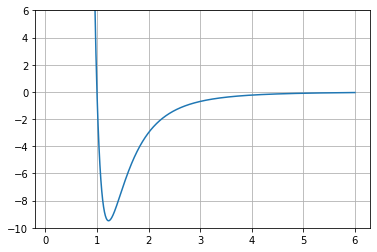

In [347]:
x = np.linspace(0.1,6,1000)
def f(x):
    return 1/(x)
    
@jit    
def lj(distances,epsilon=1):
    lennard_jones = epsilon*( (2/distances)**6 - 4*(2/distances)**4)
    return lennard_jones

plt.ylim(-10,6)
plt.plot(x, lj(x))
plt.grid()

In [432]:
@jit
def dist_penalty(p, a):
    distances = f(E_fn(a, p)).sum()
    return distances

@jit
def loss(p, a, b, c):
    all_distances = E_fn(a, p)
    distance_term = lj(all_distances).sum()
#    distance_term = dist_penalty(p, a)
#    volume_term = vmake_vol(p[c]).sum()
    bond_lengths = get_bond_lengths(p, b)*10
    bond_term = (bond_lengths-3)**4
    
    return distance_term+bond_term.sum()

In [433]:
loss(points, atom_centres, allbonds,cells)

DeviceArray(407923.62, dtype=float32)

In [437]:
get_bond_lengths(positions, allbonds)*10-3

DeviceArray([ 3.6773796,  5.030628 , -1.2495377, ...,  2.090404 ,
              1.8767033,  1.0720959], dtype=float32)

In [438]:
gl = grad(loss)

In [439]:
gl(points, atom_centres, allbonds, cells)

DeviceArray([[-5.4028889e+01,  6.1720482e+01,  2.7003613e-01],
             [ 5.2582611e+01,  5.6727032e+01,  1.1312449e-01],
             [-5.2912796e+01, -5.7417076e+01,  9.9118516e-02],
             ...,
             [-2.8416574e+02,  8.9059625e+02,  1.5781898e+02],
             [-2.8408890e+02,  8.9062860e+02, -1.5768669e+02],
             [-3.4390607e+02,  6.6518109e+02,  9.0187348e-02]],            dtype=float32)

In [444]:
positions = points.copy()

avg_sq_grad = np.zeros_like(positions)
gamma=0.9
eps=1e-8
mass = 1
lr = 0.01 #step size

for _ in tqdm_notebook(range(300)):
    g = gl(positions, atom_centres, allbonds, cells)
    #try shifting positions by a small constant:
    #normalize gradients to 1:
#     g_norm = np.linalg.norm(g,axis=1)
#     g /= g_norm[:,None]
#     newpos = positions-g/100
    
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1. - gamma)
    newpos = positions - lr * g / np.sqrt(avg_sq_grad + eps)
    
    print(np.max(np.linalg.norm(positions-newpos, axis=1)))
    positions=newpos
    

<ipython-input-444-dc96b605a100>:9: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.054772444
0.053374596
0.04631705
0.045143116
0.035424978
0.03397836
0.03261511
0.032610092
0.030542614
0.025137337
0.025245229
0.02432419
0.025280407
0.026779974
0.024203729
0.024856023
0.022937723
0.022486707
0.023082808
0.02629968
0.028826104
0.026429936
0.02529964
0.02516438
0.024603259
0.025252584
0.024765424
0.024952142
0.026135767
0.02564809
0.023696093
0.029545575
0.026463421
0.02398679
0.024046063
0.024683101
0.02396527
0.02630312
0.024831414
0.028710954
0.028891547
0.025299923
0.026375169
0.027053671
0.025192603
0.027193462
0.027583143
0.02498263
0.023484912
0.024184484
0.023291476
0.023677025
0.026861794
0.026543317
0.026256163
0.026204929
0.024977222
0.024954211
0.025549829
0.024059711
0.026887372
0.02599591
0.026090125
0.02421964
0.024131877
0.026158638
0.025895167
0.026129445
0.028141703
0.02693494
0.026297363
0.025263242
0.026140833
0.025162825
0.026567493
0.02987909
0.028973138
0.026128042
0.026065908
0.025369423
0.02441366
0.024668297
0.026131334
0.025159575
0.0257340

In [445]:
plotly_scatter([np.vstack([golden_spiral(270,1.4)+i for i in atom_centres]), points, positions], [10,5,3])
#plotly_scatter([np.vstack([golden_spiral(270,1.4)+i for i in atom_centres]), positions], [10,3])

#plotly_scatter([atom_centres, points, positions], [20,5,3])
#plotly_scatter([atom_centres, positions], [20,3])

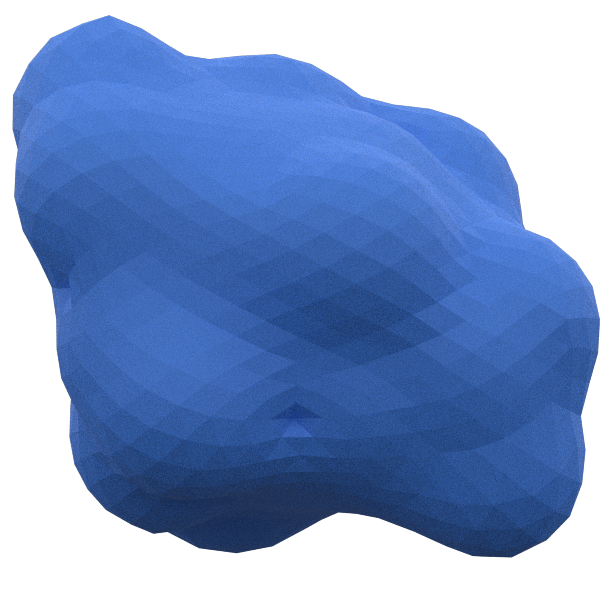

In [456]:
import fresnel
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=positions[cells].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=200, h=600, w=600)